In [1]:
#import src.functions as func
from src.functions import load_data, baseline_model_fit_save, bootstrap_evaluate, compute_confidence_interval, plot_metrics_boxplot, elasticnet_feature_selection, hyperparameter_tuning_save
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR

In [2]:
dev_data_path = "data/assignment1_dev_set.csv"
val_data_path = "data/assignment1_val_set.csv"
# Load and split data
X_train, y_train = load_data(dev_data_path)
X_test, y_test = load_data(val_data_path)


Baseline model ElasticNet trained and saved.
Bootstrapping evaluation for ElasticNet on evaluation data...


c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  

95% CI for RMSE: (np.float64(3.5737134360090925), np.float64(4.709459153404227))
95% CI for MAE: (np.float64(2.6064890256060758), np.float64(3.2927011769414154))
95% CI for R2: (np.float64(-0.22008140150587144), np.float64(0.020817476925285103))
Baseline model SVR trained and saved.
Bootstrapping evaluation for SVR on evaluation data...


c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\M

95% CI for RMSE: (np.float64(3.3374133113792315), np.float64(4.574523900028227))
95% CI for MAE: (np.float64(2.391738467305707), np.float64(3.0853610048244278))
95% CI for R2: (np.float64(-0.06962358672852388), np.float64(0.07414172123092469))
Baseline model BayesianRidge trained and saved.
Bootstrapping evaluation for BayesianRidge on evaluation data...


c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without f

95% CI for RMSE: (np.float64(3.329520388395785), np.float64(4.494324149123915))
95% CI for MAE: (np.float64(2.450919338409981), np.float64(3.0582174298798965))
95% CI for R2: (np.float64(-0.03895650464502292), np.float64(0.09047744105891174))


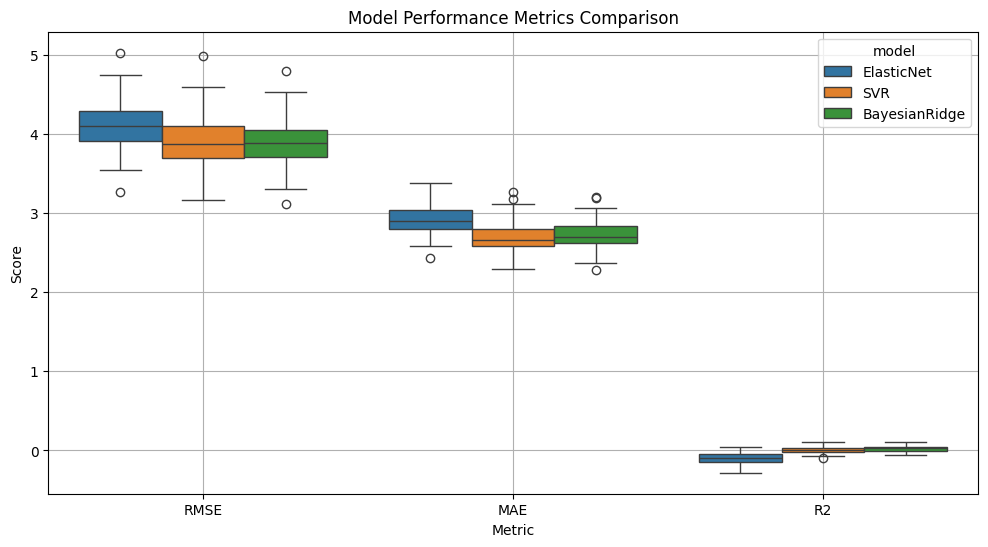

In [3]:
# Define models
models = {
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVR": SVR(C=1.0, epsilon=0.2),
    "BayesianRidge": BayesianRidge()
}

evaluation_results = []

# Evaluate each model on the development dataset and then on the evaluation dataset
for name, model in models.items():
    
    baseline = baseline_model_fit_save(model, name, X_train=X_train, y_train=y_train, prefix="baseline")
    print(f"Baseline model {name} trained and saved.")
    
    print(f"Bootstrapping evaluation for {name} on evaluation data...")
    eval_metrics = bootstrap_evaluate(model, X_test, y_test, n_bootstraps=100)
    rmse_ci = compute_confidence_interval(eval_metrics['RMSE'])
    mae_ci = compute_confidence_interval(eval_metrics['MAE'])
    r2_ci = compute_confidence_interval(eval_metrics['R2'])

    print("95% CI for RMSE:", rmse_ci)
    print("95% CI for MAE:", mae_ci)
    print("95% CI for R2:", r2_ci)
    eval_metrics['model'] = name
    evaluation_results.append(eval_metrics)

# Combine evaluation results for boxplot comparison
combined_eval_df_baseline = pd.concat(evaluation_results, ignore_index=True)


# Plot the evaluation metrics for all models
plot_metrics_boxplot(combined_eval_df_baseline, save_path="plots/baseline_evaluation_metrics_boxplot.png")

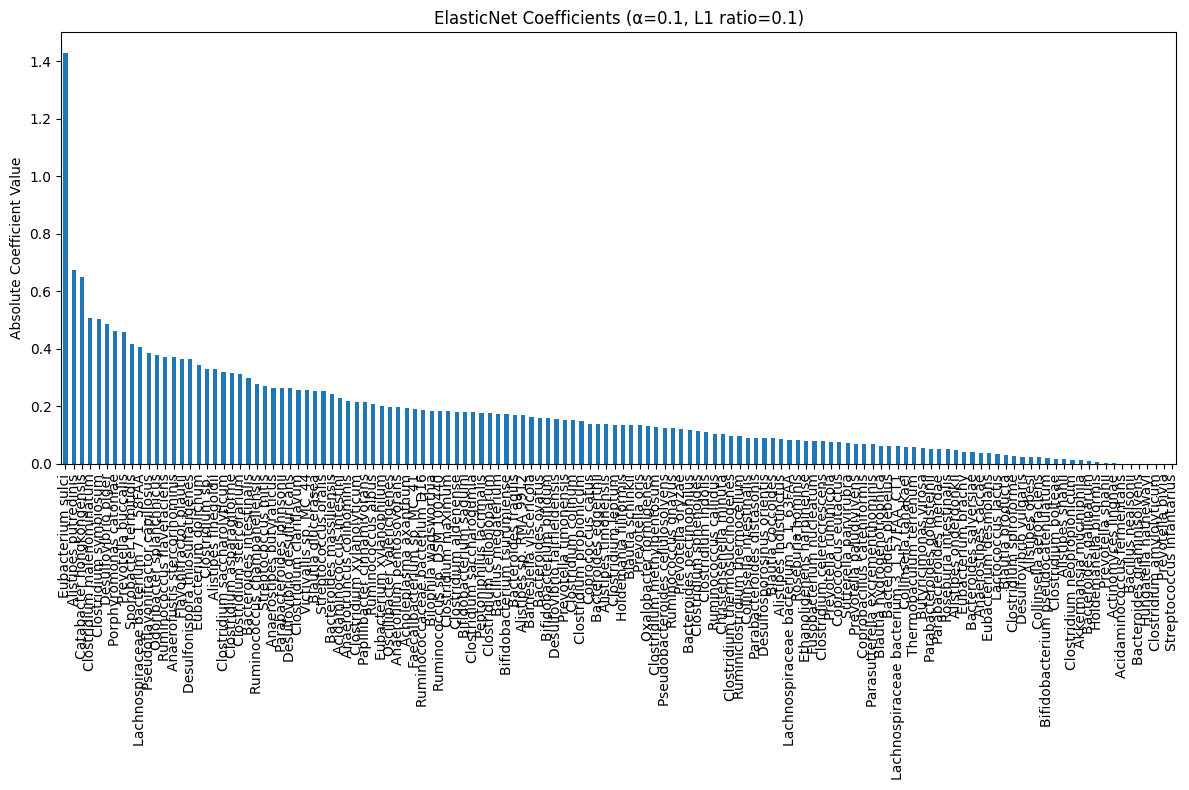

In [4]:
selected_features, coefs = elasticnet_feature_selection(X_train, y_train, 
                       alpha=0.1, l1_ratio=0.1)


Bootstrapping evaluation for ElasticNet on evaluation data after feature selection...
95% CI for RMSE: (np.float64(3.6828742358991593), np.float64(4.637643822668097))
95% CI for MAE: (np.float64(2.5639361510151746), np.float64(3.230107464352356))
95% CI for R2: (np.float64(-0.3084300740886252), np.float64(0.06572976092532523))
Bootstrapping evaluation for SVR on evaluation data after feature selection...


c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  

95% CI for RMSE: (np.float64(3.3007969182140346), np.float64(4.555650119309954))
95% CI for MAE: (np.float64(2.3741867085498347), np.float64(3.0387360995999773))
95% CI for R2: (np.float64(-0.06632912053456995), np.float64(0.0886661227977562))
Bootstrapping evaluation for BayesianRidge on evaluation data after feature selection...


c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(
c:\Users\izabe\uni\MLinCB\MLinCB-Assignment-1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without f

95% CI for RMSE: (np.float64(3.7724846911695504), np.float64(4.765700234396623))
95% CI for MAE: (np.float64(2.6388564747942485), np.float64(3.313242789921046))
95% CI for R2: (np.float64(-0.4532653053360524), np.float64(0.03469649671846842))


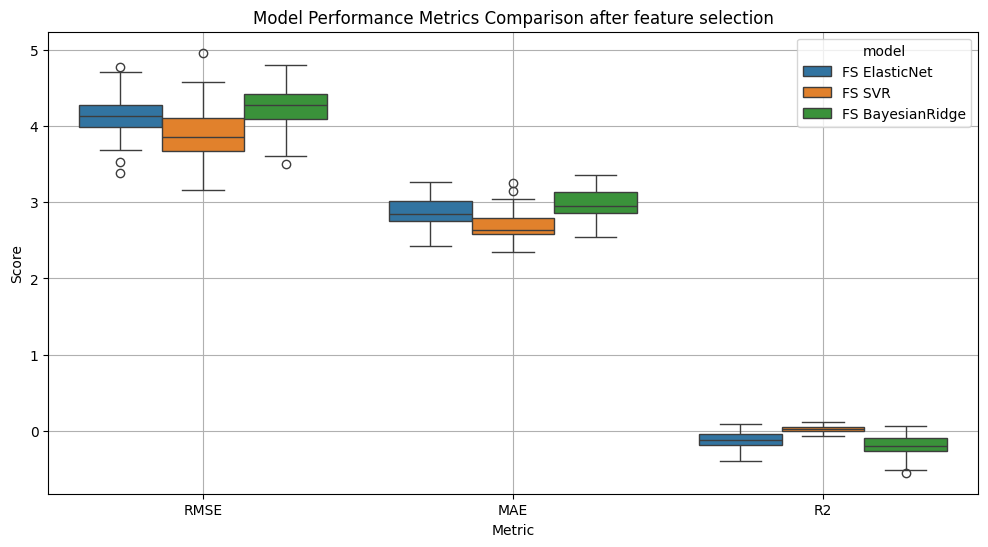

In [5]:
# Define models
models = {
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVR": SVR(C=1.0, epsilon=0.2),
    "BayesianRidge": BayesianRidge()
}

    
# Create DataFrame with selected features
X_train_selected = pd.DataFrame(X_train, columns=selected_features)
X_test_selected = pd.DataFrame(X_test, columns=selected_features)

evaluation_results = []

# Evaluate each model on the development dataset and then on the evaluation dataset
for name, model in models.items():
    
    baseline = baseline_model_fit_save(model, name, X_train=X_train_selected, y_train=y_train, prefix="FS_")
    
    print(f"Bootstrapping evaluation for {name} on evaluation data after feature selection...")
    eval_metrics = bootstrap_evaluate(model, X_test_selected, y_test, n_bootstraps=100)
    rmse_ci = compute_confidence_interval(eval_metrics['RMSE'])
    mae_ci = compute_confidence_interval(eval_metrics['MAE'])
    r2_ci = compute_confidence_interval(eval_metrics['R2'])

    print("95% CI for RMSE:", rmse_ci)
    print("95% CI for MAE:", mae_ci)
    print("95% CI for R2:", r2_ci)
    eval_metrics['model'] = f"FS {name}"
    evaluation_results.append(eval_metrics)

# Combine evaluation results for boxplot comparison
combined_eval_df = pd.concat(evaluation_results, ignore_index=True)


# Plot the evaluation metrics for all models
plot_metrics_boxplot(combined_eval_df, name = "Model Performance Metrics Comparison after feature selection", save_path="plots/FS_evaluation_metrics_boxplot.png")


=== Tuning ElasticNet ===
Best parameters: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': np.float64(0.1), 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

=== Tuning SVR ===
Best parameters: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 2, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

=== Tuning BayesianRidge ===
Best parameters: {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 0.0001, 'lambda_2': 1e-06, 'lambda_init': None, 'max_iter': 300, 'tol': 0.001, 'verbose': False}

=== Evaluating tuned ElasticNet ===
95% CI for RMSE: (np.float64(3.3491087036356926), np.float64(4.3993231948478755))
95% CI for MAE: (np.float64(2.44492332062143), np.float64(3.0369969485475576))
95% CI for R2: (np.float64(-0.010538061900688709), np

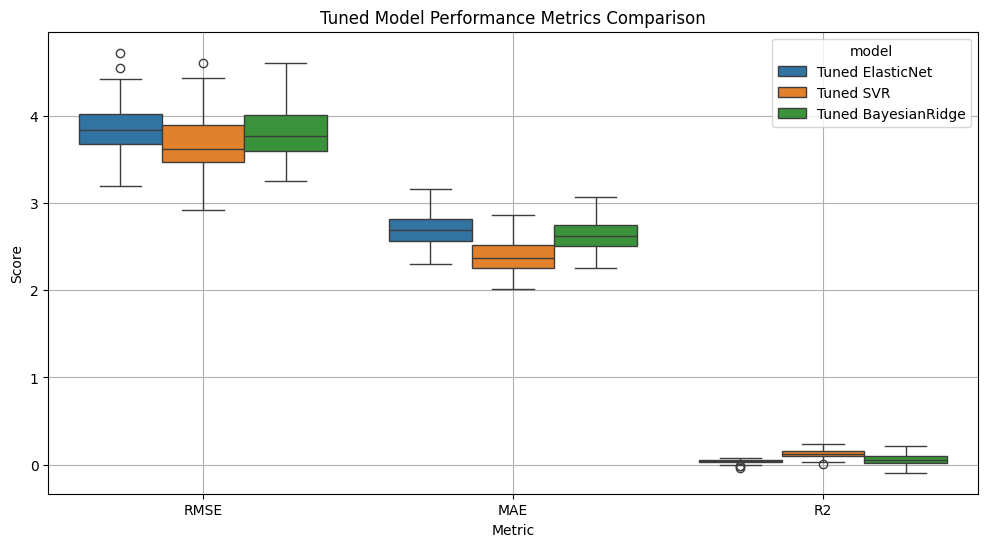

In [12]:
# Define models with their parameter grids
tuning_config = {
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "alpha": [0.001, 0.01, 0.1, 1, 10, 100],
            "l1_ratio": np.arange(0.1, 1.0, 0.01, dtype=float),
            "max_iter": [1000, 2000, 3000],
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10, 100],
            "gamma": ['scale', 'auto'],
            "epsilon": [0.01, 0.1, 0.5, 1],
            "degree": [2, 3, 4],  # Only for polynomial kernel
            "kernel": ["linear", "rbf"]
        }
    },
    "BayesianRidge": {
        "model": BayesianRidge(),
        "params": {
            "alpha_1": [1e-6, 1e-5, 1e-4, 1e-3],
            "alpha_2": [1e-6, 1e-5, 1e-4],
            "lambda_1": [1e-6, 1e-5, 1e-4]
        }
    }
}

# Perform hyperparameter tuning
tuned_models = {}
for name, config in tuning_config.items():
    print(f"\n=== Tuning {name} ===")
    best_model, cv_results = hyperparameter_tuning_save(
        config["model"], 
        name,
        config["params"],
        X_train_selected,
        y_train,
        cv=10,  # 10-fold cross-validation
    )
    tuned_models[name] = best_model
    print(f"Best parameters: {best_model.get_params()}")

# Evaluate tuned models
tuned_evaluation_results = []
for name, model in tuned_models.items():
    print(f"\n=== Evaluating tuned {name} ===")
    eval_metrics = bootstrap_evaluate(model, X_test_selected, y_test)
    
    # Calculate confidence intervals
    rmse_ci = compute_confidence_interval(eval_metrics['RMSE'])
    mae_ci = compute_confidence_interval(eval_metrics['MAE'])
    r2_ci = compute_confidence_interval(eval_metrics['R2'])

    print(f"95% CI for RMSE: {rmse_ci}")
    print(f"95% CI for MAE: {mae_ci}")
    print(f"95% CI for R2: {r2_ci}")
    
    eval_metrics['model'] = f"Tuned {name}"
    tuned_evaluation_results.append(eval_metrics)


# Plot comparison
plot_metrics_boxplot(
    pd.concat(tuned_evaluation_results),
    name="Tuned Model Performance Metrics Comparison",
    save_path="plots/tuned_comparison_boxplot.png"
)

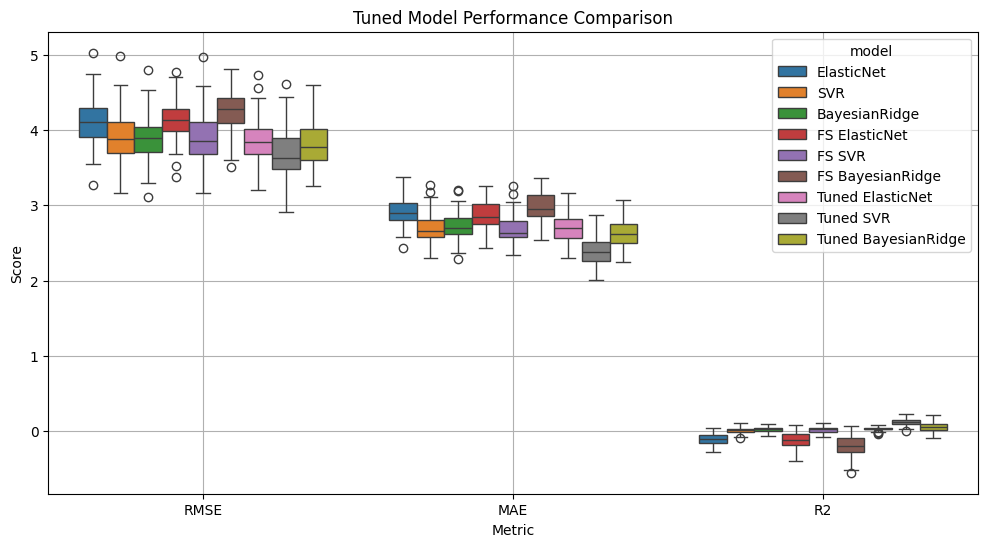

In [13]:
# Combine baseline, tuned, and additional evaluation results
full_results = pd.concat(
    [combined_eval_df_baseline, combined_eval_df, pd.concat(tuned_evaluation_results)], 
    ignore_index=True
)

# Plot comparison
plot_metrics_boxplot(
    full_results,
    name="Tuned Model Performance Comparison",
    save_path="plots/tuned_comparison_boxplot.png"
)


In [14]:
from tabulate import tabulate

# Calculate the mean for each model across the metrics
means_df = full_results.groupby('model')[['RMSE', 'MAE', 'R2']].mean().reset_index()

# Print the table in a beautiful format
table = tabulate(means_df, headers='keys', tablefmt='pipe', showindex=False)

# Print the table
print(table)


| model               |    RMSE |     MAE |          R2 |
|:--------------------|--------:|--------:|------------:|
| BayesianRidge       | 3.88569 | 2.72609 |  0.0240924  |
| ElasticNet          | 4.11539 | 2.90855 | -0.096718   |
| FS BayesianRidge    | 4.26559 | 2.97724 | -0.184742   |
| FS ElasticNet       | 4.14067 | 2.87818 | -0.114206   |
| FS SVR              | 3.89668 | 2.67954 |  0.0193458  |
| SVR                 | 3.91761 | 2.69205 |  0.00905867 |
| Tuned BayesianRidge | 3.81312 | 2.62682 |  0.0585735  |
| Tuned ElasticNet    | 3.86451 | 2.70261 |  0.034512   |
| Tuned SVR           | 3.68387 | 2.39169 |  0.123479   |


In [15]:
dev_data_path = "data/assignment1_dev_set.csv"
val_data_path = "data/assignment1_val_set.csv"
# Load and split data
X_train, y_train = load_data(dev_data_path)
X_test, y_test = load_data(val_data_path)

X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)

# Fit winner model on full data
best_model = tuned_models["SVR"]
baseline_model_fit_save(
    best_model, 
    "",
    X_train=X_full,
    y_train=y_full,
    path="/final_models",
    prefix="winner",
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Acholeplasma axanthum', 'Acidaminococcus fermentans',
       'Acidaminococcus intestini', 'Actinomyces lingnae',
       'Akkermansia muciniphila', 'Alistipes finegoldii',
       'Alistipes indistinctus', 'Alistipes obesi', 'Alistipes onderdonkii',
       'Alistipes putredinis',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=134))])),
                ('model', SVR(C=10, degree=2, epsilon=1, gamma='auto'))])